# Collaborative Filtering Model using Tensorflow

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install and import packages
import os
import random
import warnings
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import datetime
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
my_dpi = 96
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Tue Jan 10 15:15:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |    992MiB / 15109MiB |      0%      Default |
|      

In [ ]:
# Reproducibility in TF 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['AmazonReviews_RecSysDL'] = str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

In [ ]:
%cd /content/drive/MyDrive/AmazonReviews/Data/

/content/drive/MyDrive/AmazonReviews/Data


In [ ]:
# Read data
df = pd.read_csv('Movies_and_TV.csv', header=None, skiprows=[0],
                 low_memory=False)
df = df.drop_duplicates()

# Name columns
df.columns = ['item', 'reviewerID', 'rating', 'timestamp']

print('Sample observations:')
df.head()

Sample observations:


,item,reviewerID,rating,timestamp
0,0001527665,A2VHSG6TZHU1OB,5.0,1361145600
1,0001527665,A23EJWOW1TLENE,5.0,1358380800
2,0001527665,A1KM9FNEJ8Q171,5.0,1357776000
3,0001527665,A38LY2SSHVHRYB,4.0,1356480000
4,0001527665,AHTYUW2H1276L,5.0,1353024000


In [ ]:
# Data summary
def data_summary(df):
    print('Number of Rows: {}, Columns: {}'.format(df.shape[0], df.shape[1]))
    a = pd.DataFrame()
    a['Number of Unique Values'] = df.nunique()
    a['Number of Missing Values'] = df.isnull().sum()
    a['Data type of variable'] = df.dtypes
    print(a)

print('\nData Summary')     
print(data_summary(df))

df = df.drop(['timestamp'], axis=1)


Data Summary
Number of Rows: 8522125, Columns: 4
            Number of Unique Values  Number of Missing Values  \
item                         182032                         0   
reviewerID                  3826085                         0   
rating                            5                         0   
timestamp                      7476                         0   

           Data type of variable  
item                      object  
reviewerID                object  
rating                   float64  
timestamp                  int64  
None


<font size="4">The top 10 reviewers with the most number of ratings in the initial set shows that they have over 1,600 reviews.<font>

In [ ]:
reviewers_top10 = df.groupby('reviewerID').size().sort_values(ascending=False)[:10]
print('Reviewers with highest number of ratings in initial set:')
print(reviewers_top10)

Reviewers with highest number of ratings in initial set:
reviewerID
AV6QDP8Q0ONK4     4101
A1GGOC9PVDXW7Z    2114
ABO2ZI2Y5DQ9T     2073
A328S9RN3U5M68    2059
A3MV1KKHX51FYT    1989
A2EDZH51XHFA9B    1842
A3LZGLA88K0LA0    1814
A16CZRQL23NOIW    1808
AIMR915K4YCN      1719
A2NJO6YE954DBH    1699
dtype: int64


<font size="4">The top 10 items in the initial set shows the highest item has 24,554 ratings while the 10th highest items has 14,174 ratings. <font>

In [ ]:
items_top10 = df.groupby('item').size().sort_values(ascending=False)[:10]
print('Items with highest number of ratings in initial set:')
print(items_top10)

Items with highest number of ratings in initial set:
item
B00YSG2ZPA    24554
B00006CXSS    24485
B00AQVMZKQ    21015
B01BHTSIOC    20889
B00NAQ3EOK    16857
6305837325    16671
B00WNBABVC    15205
B017S3OP7A    14795
B009934S5M    14481
B00FL31UF0    14174
dtype: int64


<font size="4">Since the data is sparse, a new integer id is created for `item` rather the initial string variable. <font>

In [ ]:
value_counts = df['item'].value_counts(dropna=True, sort=True)
df1 = pd.DataFrame(value_counts)
df1 = df1.reset_index()
df1.columns = ['item_unique', 'counts'] 
df1 = df1.reset_index()
df1.rename(columns={'index': 'item_id'}, inplace=True)
df1 = df1.drop(['counts'], axis=1)
df = pd.merge(df, df1, how='left', left_on=['item'],
              right_on=['item_unique'])
df = df.drop_duplicates()
df = df.drop(['item_unique'], axis=1)

del value_counts, df1

<font size="4">The same process is used for `reviewerID`. A key is created for merging the new integer variables that later be used to join the original data. For this set, the unnecessary keys are then dropped.<font>

In [ ]:
value_counts = df['reviewerID'].value_counts(dropna=True, sort=True)
df1 = pd.DataFrame(value_counts)
df1 = df1.reset_index()
df1.columns = ['id_unique', 'counts'] 
df1 = df1.reset_index()
df1.rename(columns={'index': 'reviewer_id'}, inplace=True)
df1 = df1.drop(['counts'], axis=1)
df = pd.merge(df, df1, how='left', left_on=['reviewerID'],
              right_on=['id_unique'])
df = df.drop_duplicates()
df = df.drop(['id_unique'], axis=1)

del value_counts, df1

df = df.drop(['item', 'reviewerID'], axis=1)

<font size="4">The data is then filtered to reviewers who have greater than or equal to 25 reviews due to sparsity. This results in a set containing 1,113,396 ratings with 19,639 unique reviewers and 103,687 unique items. The majority of items are rated 5 star.<font>

In [ ]:
reviewer_count = df.reviewer_id.value_counts()
df = df[df.reviewer_id.isin(reviewer_count[reviewer_count >= 25].index)]
df = df.drop_duplicates()

del reviewer_count

print('- Number of ratings after filtering: ', len(df))
print('- Number of unique reviewers: ', df['reviewer_id'].nunique())
print('- Number of unique items: ', df['item_id'].nunique())
print('\n')

for i in range(1,6):
  print('- Number of items with {0} rating = {1}'.format(i, df[df['rating'] == i].shape[0]))

- Number of ratings after filtering:  1113396
- Number of unique reviewers:  19639
- Number of unique items:  103687


- Number of items with 1 rating = 59470
- Number of items with 2 rating = 65558
- Number of items with 3 rating = 141436
- Number of items with 4 rating = 252584
- Number of items with 5 rating = 594348


## Prepare the data


In [ ]:
df['item_id'] = df['item_id'].apply(lambda x: f'item_{x}')
df['reviewer_id'] = df['reviewer_id'].apply(lambda x: f'reviewer_{x}')
df['rating'] = df['rating'].apply(lambda x: float(x))

print(f'Number of reviewers: {len(df.reviewer_id.unique())}')
print(f'Number of items: {len(df.item_id.unique())}')
print(f'Number of ratings: {len(df.index)}')

Number of reviewers: 19639
Number of items: 103687
Number of ratings: 1113396


## Create train and eval data splits

In [ ]:
random_selection = np.random.rand(len(df.index)) <= 0.80
train_data = df[random_selection]
eval_data = df[~random_selection]

train_data.to_csv('train_filtered.csv', index=False, sep='|', header=False)
eval_data.to_csv('eval_filtered.csv', index=False, sep='|', header=False)
print(f'Train data split: {len(train_data.index)}')
print(f'Eval data split: {len(eval_data.index)}')
print('Train and eval data files are saved.')

Train data split: 890562
Eval data split: 222834
Train and eval data files are saved.


## Define dataset metadata and hyperparameters

In [ ]:
csv_header = list(df.columns)
reviewer_vocabulary = list(df.reviewer_id.unique())
item_vocabulary = list(df.item_id.unique())
target_feature_name = 'rating'
learning_rate = 0.0001
batch_size = 1024
num_epochs = 30
base_embedding_dim = 64
DATADIR = '/content/drive/MyDrive/AmazonReviews/Data/'

## Train and evaluate the model
Load the data into a dataset with each element of the dataset as a (features, labels) tuple that is a batch of rows. The features dictionary maps feature column names to `Tensors` containing the corresponding feature data, and labels is a `Tensor` containing the batch's label data. The model is compiled with the `optimizer`, `loss` and `metrics`, and the model is trained.

In [ ]:
def get_dataset_from_csv(path, batch_size=1024, shuffle=True):

  # Load data from csv
  csv_file_path = tf.io.gfile.glob(path)
  
  return tf.data.experimental.make_csv_dataset(
      csv_file_path,
      batch_size=batch_size,
      column_names=csv_header,
      label_name=target_feature_name,
      num_epochs=1,
      header=False,
      field_delim='|',
      shuffle=shuffle)

In [ ]:
def run_experiment(model):

    # Read the training & test data
    train_dataset = get_dataset_from_csv(os.path.join(DATADIR, 
                                                      'train_filtered.csv'), 
                                         batch_size)
    eval_dataset = get_dataset_from_csv(os.path.join(DATADIR, 
                                                     'eval_filtered.csv'),
                                        batch_size, shuffle=False)
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(name='mae')])

    # Fit the model
    history = model.fit(train_dataset, epochs=num_epochs, 
                        validation_data=eval_dataset, 
                        callbacks=callbacks_list)
    return history

## Baseline Collaborative Filtering Model

### Implement embedding encoder

In [ ]:
def embedding_encoder(vocabulary, embedding_dim, num_oov_indices=0, name=None):
  
    return keras.Sequential(
        [layers.StringLookup(vocabulary=vocabulary, mask_token=None, 
                             num_oov_indices=num_oov_indices),
         layers.Embedding(input_dim=len(vocabulary) + num_oov_indices, 
                          output_dim=embedding_dim),],
                          name=f'{name}_embedding' if name else None)

### Implement the baseline model: Batch 1024

In [ ]:
def create_baseline_model():

    # Use reviewer as an input for reviewer embedding
    reviewer_input = layers.Input(name='reviewer_id', shape=(), dtype=tf.string)
    reviewer_embedding = embedding_encoder(vocabulary=reviewer_vocabulary, 
                                           embedding_dim=base_embedding_dim, 
                                           name='reviewer')(reviewer_input)

    # Use item as an input for item embedding
    item_input = layers.Input(name='item_id', shape=(), dtype=tf.string)
    item_embedding = embedding_encoder(vocabulary=item_vocabulary, 
                                       embedding_dim=base_embedding_dim, 
                                       name='item')(item_input)

    # Compute dot product similarity between reviewer and item embeddings
    logits = layers.Dot(axes=1, name='dot_similarity')([reviewer_embedding, 
                                                        item_embedding])
    # Convert to rating scale
    prediction = keras.activations.sigmoid(logits) * 5

    # Create the model
    model = keras.Model(inputs=[reviewer_input, item_input], outputs=prediction, 
                        name='baseline_model')
    
    return model

In [ ]:
# Create baseline model
baseline_model = create_baseline_model()

# Model summary
baseline_model.summary()

Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 reviewer_id (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 item_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 reviewer_embedding (Sequential  (None, 64)          1256896     ['reviewer_id[0][0]']            
 )                                                                                                
                                                                                                  
 item_embedding (Sequential)    (None, 64)           6635968     ['item_id[0][0]']   

Notice that the number of trainable parameters is 7,892,864

In [ ]:
# Set path for results
%cd /content/drive/MyDrive/AmazonReviews/Models/DL/Models/

/content/drive/MyDrive/AmazonReviews/Models/DL/Models


In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [ ]:
# Set up callbacks
filepath = 'baselineEmbed64_MoviesTV_weights_only_b1024.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_loss', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Fit baseline model
history = run_experiment(baseline_model)

Epoch 1/30
870/870 [==============================] - 141s 157ms/step - loss: 4.0122 - mae: 1.8476 - val_loss: 4.0184 - val_mae: 1.8491
Epoch 2/30
870/870 [==============================] - 131s 151ms/step - loss: 4.0040 - mae: 1.8456 - val_loss: 4.0182 - val_mae: 1.8491
Epoch 3/30
870/870 [==============================] - 132s 152ms/step - loss: 3.9942 - mae: 1.8432 - val_loss: 4.0175 - val_mae: 1.8489
Epoch 4/30
870/870 [==============================] - 136s 156ms/step - loss: 3.9822 - mae: 1.8403 - val_loss: 4.0155 - val_mae: 1.8484
Epoch 5/30
870/870 [==============================] - 136s 156ms/step - loss: 3.9661 - mae: 1.8363 - val_loss: 4.0103 - val_mae: 1.8471
Epoch 6/30
870/870 [==============================] - 140s 161ms/step - loss: 3.9430 - mae: 1.8306 - val_loss: 3.9983 - val_mae: 1.8441
Epoch 7/30
870/870 [==============================] - 138s 158ms/step - loss: 3.9082 - mae: 1.8219 - val_loss: 3.9740 - val_mae: 1.8380
Epoch 8/30
870/870 [============================

In [ ]:
# Save model
baseline_model.save('./baselineEmbed64_MoviesTV_batchb1024_tf.h5', 
                    save_format='tf')

# Load model for more training or later use
#filepath = 'baselineEmbed64_MoviesTV_weights_only_b1024.h5'
#model = tf.keras.models.load_model('./baselineEmbed64_MoviesTV_batchb1024_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

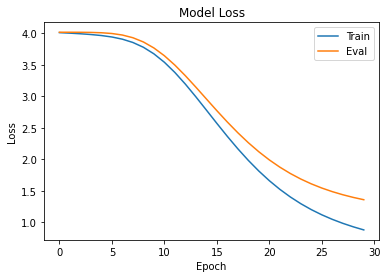

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_baselineEmbed64_MoviesTV_filtered_batchb1024_30epochs_Loss.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Loss over epochs
loss = pd.DataFrame(history.history['loss'], columns=['loss'])

# Val_loss over epochs
val_loss = pd.DataFrame(history.history['val_loss'], columns=['val_loss'])

# Save loss in df
dat = pd.concat([loss, val_loss], axis=1)
dat.to_csv('/baselineEmbed64_MoviesTV_batchb1024_10epochs.csv', index=False)

In [ ]:
# Load model for more training or later use
model = tf.keras.models.load_model('./baselineEmbed64_MoviesTV_batchb1024_tf.h5')

# Show the model architecture
model.summary()

Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 reviewer_id (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 item_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 reviewer_embedding (Sequential  (None, 64)          1256896     ['reviewer_id[0][0]']            
 )                                                                                                
                                                                                                  
 item_embedding (Sequential)    (None, 64)           6635968     ['item_id[0][0]']   

In [ ]:
# Load validation set
eval_dataset = get_dataset_from_csv('eval_filtered.csv', batch_size, 
                                    shuffle=False)

In [ ]:
# Evaluate with the test data
result = model.evaluate(eval_dataset, return_dict=True, verbose=0)
print('\nEvaluation on the test set:')
display(result)


Evaluation on the test set:


{'loss': 1.359154462814331, 'mae': 0.9445576071739197}

## Memory-Efficient Model

### Implement Quotient-Remainder embedding as a layer

The Quotient-Remainder technique works by creating *two* `num_buckets X embedding_dim` embedding tables for a set of vocabulary and  embedding size
`embedding_dim` where `num_buckets` is much smaller than `vocabulary_size`, rather than creating a `vocabulary_size X embedding_dim` embedding table.

An embedding for a given item `index` is generated by:

1. Computing the `quotient_index` as `index // num_buckets`.
2. Computing the `remainder_index` as `index % num_buckets`.
3. Lookup `quotient_embedding` from the first embedding table using `quotient_index`.
4. Lookup `remainder_embedding` from the second embedding table using `remainder_index`.
5. Returning `quotient_embedding` * `remainder_embedding`.

This technique reduces the number of embedding vectors needed to be stored and trained, as well as generating a *unique* embedding vector for each item of size `embedding_dim`.
The embeddings, `q_embedding` and `r_embedding`, can be combined using other operations like `Add` and `Concatenate`.

In [ ]:
class QREmbedding(keras.layers.Layer):
    def __init__(self, vocabulary, embedding_dim, num_buckets, name=None):
        
        super(QREmbedding, self).__init__(name=name)
        self.num_buckets = num_buckets
        self.index_lookup = layers.StringLookup(
            vocabulary=vocabulary, mask_token=None, num_oov_indices=0)
        self.q_embeddings = layers.Embedding(num_buckets, embedding_dim,)
        self.r_embeddings = layers.Embedding(num_buckets, embedding_dim,)

    # Set up config
    def get_config(self):
      config = super().get_config()
      return config

    def call(self, inputs):
        # Get the item, quotient and remainder indeces
        embedding_index = self.index_lookup(inputs)
        quotient_index = tf.math.floordiv(embedding_index, self.num_buckets)
        remainder_index = tf.math.floormod(embedding_index, self.num_buckets)

        # Lookup the quotient_embedding using the quotient_index
        quotient_embedding = self.q_embeddings(quotient_index)

        # Lookup the remainder_embedding using the remainder_index
        remainder_embedding = self.r_embeddings(remainder_index)

        # Use multiplication as a combiner operation
        return quotient_embedding * remainder_embedding

### Implement Mixed Dimension embedding as a layer

Embedding vectors are trained with full dimensions
for the frequently queried items, while embedding vectors with *reduced dimensions* are trained for less frequent items. A *projection weights matrix* allows low dimension embeddings to become the full dimensions.

More precisely, we define *blocks* of items of similar frequencies. For each block,
a `block_vocab_size X block_embedding_dim` embedding table and `block_embedding_dim X full_embedding_dim`
projection weights matrix are created. Note that, if `block_embedding_dim` equals `full_embedding_dim`,
the projection weights matrix becomes an *identity* matrix. Embeddings for a given batch of item
`indices` are generated via the following steps:

1. For each block, lookup the `block_embedding_dim` embedding vectors using `indices`, and
project them to the `full_embedding_dim`.
2. If an item index does not belong to a given block, an out-of-vocabulary embedding is returned.
Each block will return a `batch_size X full_embedding_dim` tensor.
3. A mask is applied to the embeddings returned from each block in order to convert the
out-of-vocabulary embeddings to vector of zeros. That is, for each item in the batch,
a single non-zero embedding vector is returned from the all block embeddings.
4. Embeddings retrieved from the blocks are combined using *sum* to produce the final
`batch_size X full_embedding_dim` tensor.

In [ ]:
class MDEmbedding(keras.layers.Layer):
    def __init__(self, blocks_vocabulary, blocks_embedding_dims, 
                 base_embedding_dim, name=None):
        
        super(MDEmbedding, self).__init__(name=name)
        self.num_blocks = len(blocks_vocabulary)

        # Create vocab to block lookup
        keys = []
        values = []
        for block_idx, block_vocab in enumerate(blocks_vocabulary):
            keys.extend(block_vocab)
            values.extend([block_idx] * len(block_vocab))
        self.vocab_to_block = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys, values), default_value=-1)

        # Create block embedding encoders and projectors
        self.block_embedding_encoders = []
        self.block_embedding_projectors = []
      
        for idx in range(self.num_blocks):
            vocabulary = blocks_vocabulary[idx]
            embedding_dim = blocks_embedding_dims[idx]
            block_embedding_encoder = embedding_encoder(
                vocabulary, embedding_dim, num_oov_indices=1)
            self.block_embedding_encoders.append(block_embedding_encoder)
            if embedding_dim == base_embedding_dim:
                self.block_embedding_projectors.append(layers.Lambda(lambda x: x))
            else:
                self.block_embedding_projectors.append(
                    layers.Dense(units=base_embedding_dim))

    # Config layers
    def get_config(self):
      config = super().get_config()
      return config

    def call(self, inputs):

        # Get block index for each input item
        block_indicies = self.vocab_to_block.lookup(inputs)
        
        # Initialize output embeddings to zeros
        embeddings = tf.zeros(shape=(tf.shape(inputs)[0], base_embedding_dim))
        
        # Generate embeddings from blocks
        for idx in range(self.num_blocks):

            # Lookup & project embeddings from the current block to base_embedding_dim
            block_embeddings = self.block_embedding_encoders[idx](inputs)
            block_embeddings = self.block_embedding_projectors[idx](block_embeddings)

            # Create a mask to filter out embeddings of items not in the current block
            mask = tf.expand_dims(tf.cast(block_indicies == idx, 
                                          tf.dtypes.float32), 1)
            
            # Set the embeddings for the items not in the current block to zero
            block_embeddings = block_embeddings * mask
            
            # Add the block embeddings to the final embeddings
            embeddings += block_embeddings

        return embeddings

### Implement the memory-efficient model: Batch 1024

The **Quotient-Remainder** method reduces the
size of the user embeddings, and the **Mixed Dimension** method reduces the size of the
item embeddings.

The number of blocks and the dimensions of embeddings of each block are determined based on the histogram visualization of frequency of the items, potentially popularity.

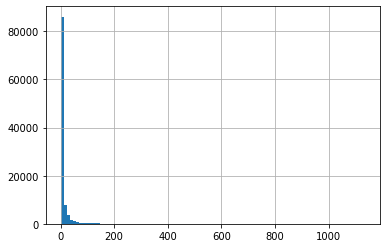

In [ ]:
item_frequencies = df['item_id'].value_counts()
item_frequencies.hist(bins=100)

In [ ]:
# Examine 5 numbr summary stats 
item_frequencies.describe()

count    103687.000000
mean         10.738048
std          32.901640
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1136.000000
Name: item_id, dtype: float64

In [ ]:
dat = df[df.groupby('item_id')['item_id'].transform('count') <= 10]
dat.shape

(234484, 3)

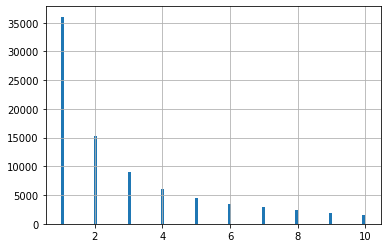

In [ ]:
item_frequencies1 = dat['item_id'].value_counts()
item_frequencies1.hist(bins=100)

In [ ]:
dat = df[df.groupby('item_id')['item_id'].transform('count') >= 10]
dat.shape

(895032, 3)

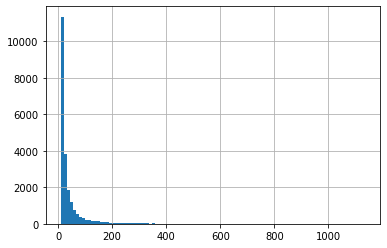

In [ ]:
item_frequencies1 = dat['item_id'].value_counts()
item_frequencies1.hist(bins=100)

In [ ]:
dat = df[df.groupby('item_id')['item_id'].transform('count') <= 100]
dat.shape

(752937, 3)

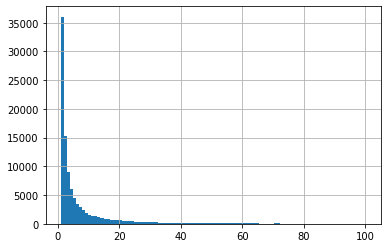

In [ ]:
item_frequencies1 = dat['item_id'].value_counts()
item_frequencies1.hist(bins=100)

In [ ]:
dat = df[df.groupby('item_id')['item_id'].transform('count') >= 100]
dat.shape

(363159, 3)

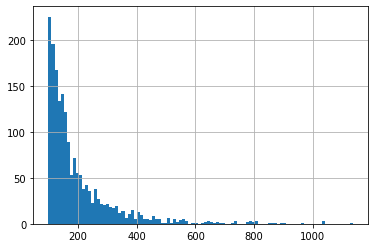

In [ ]:
item_frequencies1 = dat['item_id'].value_counts()
item_frequencies1.hist(bins=100)

The items can be grouped into three blocks, and assigned as the embedding dimensions (64, 32, and 16) with the block size split like the frequency of the items.

In [ ]:
# Create item block vocab with different dimensions
sorted_item_vocabulary = list(item_frequencies.keys())

item_blocks_vocabulary = [
    sorted_item_vocabulary[10:100],  # High popularity items block
    sorted_item_vocabulary[100:],  # Normal popularity items block
    sorted_item_vocabulary[:10]]  # Low popularity items block

item_blocks_embedding_dims = [64, 32, 16]

# Define number of embedding buckets for reviewers
reviewer_embedding_num_buckets = len(reviewer_vocabulary) // 100
print('Number of reviewer embedding buckets:', reviewer_embedding_num_buckets)

Number of reviewer embedding buckets: 196


In [ ]:
def create_memory_efficient_model():

    # Use reviewer as an input for reviewer embeddings
    reviewer_input = layers.Input(name='reviewer_id', shape=(), dtype=tf.string)
    reviewer_embedding = QREmbedding(
        vocabulary=reviewer_vocabulary,
        embedding_dim=base_embedding_dim,
        num_buckets=reviewer_embedding_num_buckets,
        name='reviewer_embedding')(reviewer_input)

    # Use item as an input for item embeddings
    item_input = layers.Input(name='item_id', shape=(), dtype=tf.string)
    item_embedding = MDEmbedding(
        blocks_vocabulary=item_blocks_vocabulary,
        blocks_embedding_dims=item_blocks_embedding_dims,
        base_embedding_dim=base_embedding_dim,
        name='item_embedding')(item_input)

    # Compute dot product similarity between reviewer and item embeddings
    logits = layers.Dot(axes=1, name='dot_similarity')(
        [reviewer_embedding, item_embedding])
    
    # Convert to rating scale
    prediction = keras.activations.sigmoid(logits) * 5

    # Create the model
    model = keras.Model(inputs=[reviewer_input, item_input], outputs=prediction, 
                        name='memory_model')
    return model

In [ ]:
# Create memory efficient model
memory_efficient_model = create_memory_efficient_model()

# Model summary
memory_efficient_model.summary()

Model: "memory_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 reviewer_id (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 item_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 reviewer_embedding (QREmbeddin  (None, 64)          25088       ['reviewer_id[0][0]']            
 g)                                                                                               
                                                                                                  
 item_embedding (MDEmbedding)   (None, 64)           3324016     ['item_id[0][0]']     

The number of trainable parameters is now 3,349,104 down from 7,892,864 which is more than 2x less than the number of parameters in the baseline model.

In [ ]:
# Set up callbacks
filepath = 'baselineFiltered_weights_only_b1024_memOpt.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath, monitor='val_loss', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Fit the model
history = run_experiment(memory_efficient_model)

Epoch 1/30
870/870 [==============================] - 139s 155ms/step - loss: 3.9922 - mae: 1.8427 - val_loss: 3.8602 - val_mae: 1.8107
Epoch 2/30
870/870 [==============================] - 129s 148ms/step - loss: 2.9061 - mae: 1.5446 - val_loss: 1.7800 - val_mae: 1.1903
Epoch 3/30
870/870 [==============================] - 127s 147ms/step - loss: 1.4770 - mae: 1.0167 - val_loss: 1.3738 - val_mae: 0.9444
Epoch 4/30
870/870 [==============================] - 125s 143ms/step - loss: 1.2883 - mae: 0.9073 - val_loss: 1.3152 - val_mae: 0.9091
Epoch 5/30
870/870 [==============================] - 133s 153ms/step - loss: 1.2071 - mae: 0.8670 - val_loss: 1.2915 - val_mae: 0.8895
Epoch 6/30
870/870 [==============================] - 132s 152ms/step - loss: 1.1569 - mae: 0.8380 - val_loss: 1.2851 - val_mae: 0.8772
Epoch 7/30
870/870 [==============================] - 133s 152ms/step - loss: 1.1255 - mae: 0.8177 - val_loss: 1.2823 - val_mae: 0.8693
Epoch 8/30
870/870 [============================

In [ ]:
# Save model
memory_efficient_model.save('./memoryEfficient_weights_only_b1024_tf.h5', 
                            save_format='tf')

# Load model for more training or later use
#filepath = 'baselineFiltered_weights_only_b1024_memOpt.h5'
#model = tf.keras.models.load_model('./memoryEfficient_weights_only_b1024_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

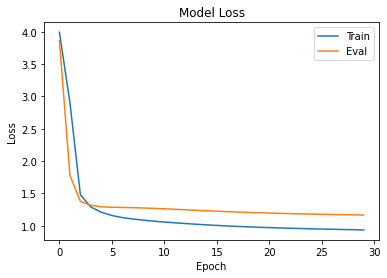

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_MovieTV_memoryEfficientEmbed64_batch1024_Loss.png', 
            dpi=my_dpi*10,bbox_inches='tight')
plt.show()

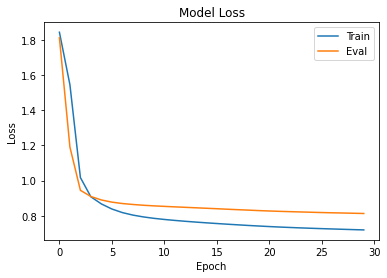

In [ ]:
# Plot mae over epochs
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_MovieTV_memoryEfficientEmbed64_batch1024_mae.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Load model for more training or later use
model = tf.keras.models.load_model('./memoryEfficient_weights_only_b1024_tf.h5')

# Show the model architecture
model.summary()

In [ ]:
# Load test set
eval_dataset = get_dataset_from_csv('eval_filtered.csv', batch_size, 
                                    shuffle=False)

In [ ]:
# Evaluate with the test data
result = model.evaluate(eval_dataset, return_dict=True, verbose=0)
print('\nEvaluation on the test set:')
display(result)


Evaluation on the test set:


{'loss': 1.359154462814331, 'mae': 0.9445576071739197}